In [ ]:
%pip install --user sklearn
%pip install --user numpy
%pip install --user matplotlib

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import KFold
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler

In [ ]:
data_matrix = np.loadtxt(open("./msd_genre_dataset/msd_genre_dataset_segpreproc_knime.csv", "rb"), delimiter=";", skiprows=1)



#Los datos del set de datos están agrupados por género. Es decir, primero están todas las filas que corresponden
#a 1 y después todas las que corresponden a 0. Se hace un shuffle para que, más tarde, en cross-validation
#no se creen unos modelos que predigan únicamente una clase.
np.random.shuffle(data_matrix)

plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.matshow(np.corrcoef(data_matrix))
plt.show()


print("Filas de la matriz: " + str(len(data_matrix)))
print("Columnas de la matriz: " + str(len(data_matrix[0])))

X = np.resize(data_matrix, (len(data_matrix), len(data_matrix[0])-1))
y = data_matrix[:,len(data_matrix[0])-1]

#Se intenta estandarizar X para lograr mejor desempeño. Sin embargo, no parece funcionar.
X = MinMaxScaler().fit_transform(X)

print("X shape" + str(X.shape))
print("y shape" + str(y.shape))



In [3]:
percentage_test = 0.2

#Porcentaje de datos dedicados a validación, relativo al número de daots de test
percentage_validation = 0.1

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = percentage_test) 

In [4]:
kf = KFold(n_splits=math.floor(1/percentage_validation))

n_max = 100
scores = []
best_neurons=0
best_score=1

for n in range(2, n_max+1, 5):

    i=0
    score=0

    #Validación cruzada de la red neuronal
    for train_index, test_index in kf.split(X):
        X_train_cv, X_validate = X[train_index], X[test_index]
        y_train_cv, y_validate = y[train_index], y[test_index]
        net = MLPClassifier(solver='lbfgs', alpha=0.000005,hidden_layer_sizes=(n,), random_state=1)
        net.fit(X_train_cv,y_train_cv)
    
        score+=net.score(X_validate, y_validate)
        i+=1
    
    score = 1- (score/i)
    scores.append(score)
    
    if score < best_score:
        best_score = score
        best_neurons = n
    
    print("Average error probability for %s neurons in one hidden layer: %s" % (n, score))

print("Lowest error probability: %s for model with %s neurons" % (best_score, best_neurons))



Average error probability for 2 neurons in one hidden layer: 0.4883832335329341
Average error probability for 7 neurons in one hidden layer: 0.49556886227544905
Average error probability for 12 neurons in one hidden layer: 0.4966467065868263
Average error probability for 17 neurons in one hidden layer: 0.4966467065868263
Average error probability for 22 neurons in one hidden layer: 0.4991616766467065
Average error probability for 27 neurons in one hidden layer: 0.4996407185628742
Average error probability for 32 neurons in one hidden layer: 0.4947305389221557
Average error probability for 37 neurons in one hidden layer: 0.4917365269461078
Average error probability for 42 neurons in one hidden layer: 0.5009580838323353
Average error probability for 47 neurons in one hidden layer: 0.4935329341317366
Average error probability for 52 neurons in one hidden layer: 0.5027544910179641
Average error probability for 57 neurons in one hidden layer: 0.4979640718562873
Average error probability for

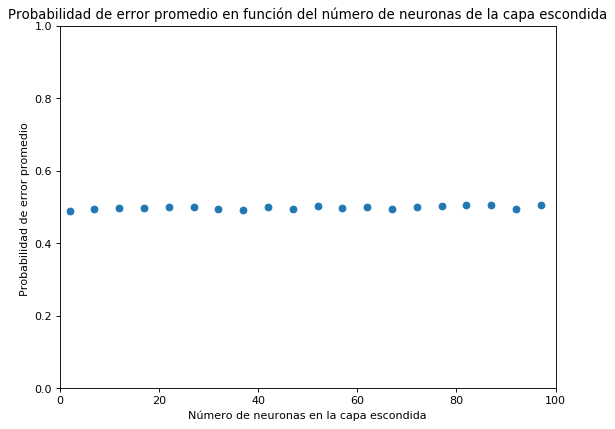

In [5]:
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

plt.plot(range(2, n_max, 5), scores, 'o')
plt.axis([0, 100, 0, 1])
plt.xlabel('Número de neuronas en la capa escondida')
plt.ylabel('Probabilidad de error promedio ')
plt.title('Probabilidad de error promedio en función del número de neuronas de la capa escondida')
plt.show()

In [6]:
#Ahora se entrena el mejor modelo con todos los datos de entrenamiento y se prueban los datos de validación

final_classifier = MLPClassifier(solver='lbfgs', alpha=0.000005,hidden_layer_sizes=(best_neurons,), random_state=1)
final_classifier.fit(X_train, y_train)

print("Probabilidad de error del modelo con %s neuronas en una capa escondida: %s" 
      % (best_neurons, 1-final_classifier.score(X_test, y_test)))


Probabilidad de error del modelo con 2 neuronas en una capa escondida: 0.4730538922155688


In [7]:
#Ahora, se toma el número de neuronas con mayor desempeño en una capa escondida y, con este número de neuronas, 
#se prueban n capas escondidas entre 2 y 100 a intervalos de 5.

kf = KFold(n_splits=math.floor(1/percentage_validation))

n_max = 20
hl_scores = []
best_layers=0
best_score=1

hid_tuple = ()

for n in range(2, n_max+1, 1):
    
    #Ahora expande la tupla, insertando best_neurons n veces hasta llegar a n
    
    hid_tuple = list(hid_tuple)
    while len(hid_tuple) != n:
        hid_tuple.append(best_neurons)
    
    hid_tuple = tuple(hid_tuple)

    i=0
    score=0

    #Validación cruzada de la red neuronal
    for train_index, test_index in kf.split(X):
        X_train_cv, X_validate = X[train_index], X[test_index]
        y_train_cv, y_validate = y[train_index], y[test_index]
        net = MLPClassifier(solver='lbfgs', alpha=0.000005,hidden_layer_sizes=hid_tuple, random_state=1)
        net.fit(X_train_cv,y_train_cv)
    
        score+=net.score(X_validate, y_validate)
        i+=1
    
    score = 1- (score/i)
    hl_scores.append(score)
    
    if score < best_score:
        best_score = score
        best_layers = n
    
    print("Average error probability for %s neurons in %s hidden layers: %s" % (best_neurons, n,score))
    
    
print("Lowest error probability: %s for model with %s hidden layers" % (best_score, best_layers))



Average error probability for 2 neurons in 2 hidden layers: 0.4809580838323353
Average error probability for 2 neurons in 3 hidden layers: 0.4809580838323353
Average error probability for 2 neurons in 4 hidden layers: 0.4809580838323353
Average error probability for 2 neurons in 5 hidden layers: 0.4809580838323353
Average error probability for 2 neurons in 6 hidden layers: 0.4809580838323353
Average error probability for 2 neurons in 7 hidden layers: 0.4809580838323353
Average error probability for 2 neurons in 8 hidden layers: 0.4809580838323353
Average error probability for 2 neurons in 9 hidden layers: 0.4809580838323353
Average error probability for 2 neurons in 10 hidden layers: 0.4809580838323353
Average error probability for 2 neurons in 11 hidden layers: 0.4809580838323353
Average error probability for 2 neurons in 12 hidden layers: 0.4809580838323353
Average error probability for 2 neurons in 13 hidden layers: 0.4809580838323353
Average error probability for 2 neurons in 14 hi

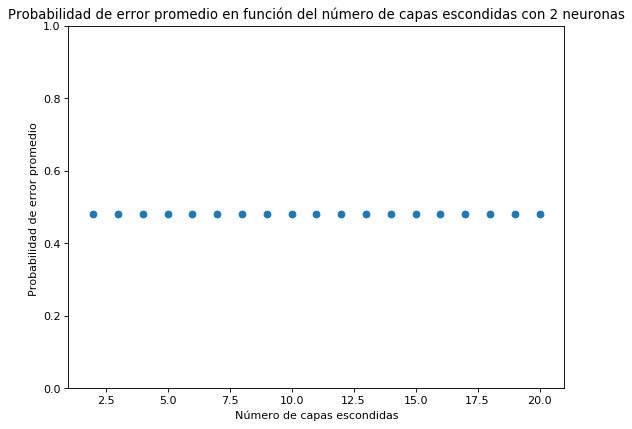

In [8]:
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

plt.plot(range(2, n_max+1, 1), hl_scores, 'o')
plt.axis([1, 21, 0, 1])
plt.xlabel('Número de capas escondidas')
plt.ylabel('Probabilidad de error promedio ')
plt.title('Probabilidad de error promedio en función del número de capas escondidas con %s neuronas' 
          % best_neurons)
plt.show()

In [9]:
#Ahora se entrena el mejor modelo con todos los datos de entrenamiento y se prueban los datos de validación

hid_tuple_final = ()
hid_tuple_final = list(hid_tuple_final)

while len(hid_tuple_final) != best_layers:
    hid_tuple_final.append(best_neurons)
    
hid_tuple_final = tuple(hid_tuple_final)

final_classifier = MLPClassifier(solver='lbfgs', alpha=0.000005,hidden_layer_sizes=hid_tuple_final, random_state=1)
final_classifier.fit(X_train, y_train)

print("Probabilidad de error del modelo con %s neuronas en %s capas escondida: %s" 
      % (best_neurons, best_layers, 1-final_classifier.score(X_test, y_test)))


Probabilidad de error del modelo con 2 neuronas en 2 capas escondida: 0.4730538922155688
